## Ciência de Dados - Trabalho Prático

> **Nomes:** Bruno Santos Fernandes, João Paulo Moura Clevelares, Thamya Vieira Hashimoto Donadia <br>
> **Matrículas:** 2021100784, 2021100149, 2021100146 <br>
> **E-mails:** {bruno.s.fernandes, joao.clevelares, thamya.donadia}@edu.ufes.br <br>
> **Curso:** Engenharia de Computação <br>


### Metodologia

#### Instalação de bibliotecas

In [270]:
# importação de bibliotecas
import numpy as np
import pandas as pd
import string
import unidecode

import nltk
nltk.download('punkt_tab')
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans


[nltk_data] Downloading package punkt_tab to /home/joao/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/joao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Pré-processamento dos dados textuais

In [271]:
# carregamento do dataset 
df = pd.read_csv("./filmes.csv")
df.head()

,genres,averageRating,numVotes,sinopse,primaryTitle,startYear,runtimeMinutes,actors_names,directors_names
0,Family,7.1,387992,When two kids find and play a magical board ga...,Jumanji,1995,104,['Robin Williams' 'Jonathan Hyde' 'Jonathan Hy...,['Joe Johnston']
1,Romance,6.7,30265,John and Max resolve to save their beloved bai...,Grumpier Old Men,1995,101,['Walter Matthau' 'Jack Lemmon' 'Burgess Mered...,['Howard Deutch']
2,Romance,6.0,12585,"Based on Terry McMillan's novel, this film fol...",Waiting to Exhale,1995,124,['Gregory Hines' 'Dennis Haysbert' 'Mykelti Wi...,['Forest Whitaker']
3,"Romance,Family",6.1,42555,George Banks must deal not only with his daugh...,Father of the Bride Part II,1995,106,['Steve Martin' 'Martin Short' 'George Newbern...,['Charles Shyer']
4,"Crime,Action",8.3,738636,A group of high-end professional thieves start...,Heat,1995,170,['Al Pacino' 'Robert De Niro' 'Val Kilmer' 'Jo...,['Michael Mann']


In [272]:
# obtenção das informações gerais do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30358 entries, 0 to 30357
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   genres           30358 non-null  object 
 1   averageRating    30358 non-null  float64
 2   numVotes         30358 non-null  int64  
 3   sinopse          30358 non-null  object 
 4   primaryTitle     30358 non-null  object 
 5   startYear        30358 non-null  int64  
 6   runtimeMinutes   30358 non-null  object 
 7   actors_names     30358 non-null  object 
 8   directors_names  30358 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 2.1+ MB


In [273]:
# verificando as features do dataset
df.columns

Index(['genres', 'averageRating', 'numVotes', 'sinopse', 'primaryTitle',
       'startYear', 'runtimeMinutes', 'actors_names', 'directors_names'],
      dtype='object')

In [274]:
# obtendo a feature a ser processada (sinopse)
df['sinopse'].head(10)

0    When two kids find and play a magical board ga...
1    John and Max resolve to save their beloved bai...
2    Based on Terry McMillan's novel, this film fol...
3    George Banks must deal not only with his daugh...
4    A group of high-end professional thieves start...
5    An ugly duckling having undergone a remarkable...
6    A former fireman takes on a group of terrorist...
7    When a powerful secret defense system is stole...
8    A widowed U.S. President running for reelectio...
9    Mel Brooks' parody of the classic vampire stor...
Name: sinopse, dtype: object

In [275]:
# divisão do texto em sentenças e palavras
df['sentences'] = df['sinopse'].apply(sent_tokenize)
df['tokens'] = df['sinopse'].apply(word_tokenize)

df.head()

,genres,averageRating,numVotes,sinopse,primaryTitle,startYear,runtimeMinutes,actors_names,directors_names,sentences,tokens
0,Family,7.1,387992,When two kids find and play a magical board ga...,Jumanji,1995,104,['Robin Williams' 'Jonathan Hyde' 'Jonathan Hy...,['Joe Johnston'],[When two kids find and play a magical board g...,"[When, two, kids, find, and, play, a, magical,..."
1,Romance,6.7,30265,John and Max resolve to save their beloved bai...,Grumpier Old Men,1995,101,['Walter Matthau' 'Jack Lemmon' 'Burgess Mered...,['Howard Deutch'],[John and Max resolve to save their beloved ba...,"[John, and, Max, resolve, to, save, their, bel..."
2,Romance,6.0,12585,"Based on Terry McMillan's novel, this film fol...",Waiting to Exhale,1995,124,['Gregory Hines' 'Dennis Haysbert' 'Mykelti Wi...,['Forest Whitaker'],"[Based on Terry McMillan's novel, this film fo...","[Based, on, Terry, McMillan, 's, novel, ,, thi..."
3,"Romance,Family",6.1,42555,George Banks must deal not only with his daugh...,Father of the Bride Part II,1995,106,['Steve Martin' 'Martin Short' 'George Newbern...,['Charles Shyer'],[George Banks must deal not only with his daug...,"[George, Banks, must, deal, not, only, with, h..."
4,"Crime,Action",8.3,738636,A group of high-end professional thieves start...,Heat,1995,170,['Al Pacino' 'Robert De Niro' 'Val Kilmer' 'Jo...,['Michael Mann'],[A group of high-end professional thieves star...,"[A, group, of, high-end, professional, thieves..."


In [276]:
# conversão do texto para letras minúsculas
df['tokens'] = df['tokens'].apply(lambda x: [token.lower() for token in x])
df['tokens'].head(10)

0    [when, two, kids, find, and, play, a, magical,...
1    [john, and, max, resolve, to, save, their, bel...
2    [based, on, terry, mcmillan, 's, novel, ,, thi...
3    [george, banks, must, deal, not, only, with, h...
4    [a, group, of, high-end, professional, thieves...
5    [an, ugly, duckling, having, undergone, a, rem...
6    [a, former, fireman, takes, on, a, group, of, ...
7    [when, a, powerful, secret, defense, system, i...
8    [a, widowed, u.s., president, running, for, re...
9    [mel, brooks, ', parody, of, the, classic, vam...
Name: tokens, dtype: object

In [277]:
# remoção de símbolos de pontuação de cada token
table = str.maketrans('', '', string.punctuation)
df['tokens'] = df['tokens'].apply(lambda x: [token.translate(table) for token in x])
df['tokens'].head(10)

0    [when, two, kids, find, and, play, a, magical,...
1    [john, and, max, resolve, to, save, their, bel...
2    [based, on, terry, mcmillan, s, novel, , this,...
3    [george, banks, must, deal, not, only, with, h...
4    [a, group, of, highend, professional, thieves,...
5    [an, ugly, duckling, having, undergone, a, rem...
6    [a, former, fireman, takes, on, a, group, of, ...
7    [when, a, powerful, secret, defense, system, i...
8    [a, widowed, us, president, running, for, reel...
9    [mel, brooks, , parody, of, the, classic, vamp...
Name: tokens, dtype: object

In [278]:
# conversão de caracteres especiais
df['tokens'] = df['tokens'].apply(lambda x: [unidecode.unidecode(token) for token in x])
df['tokens'].head(10)


0    [when, two, kids, find, and, play, a, magical,...
1    [john, and, max, resolve, to, save, their, bel...
2    [based, on, terry, mcmillan, s, novel, , this,...
3    [george, banks, must, deal, not, only, with, h...
4    [a, group, of, highend, professional, thieves,...
5    [an, ugly, duckling, having, undergone, a, rem...
6    [a, former, fireman, takes, on, a, group, of, ...
7    [when, a, powerful, secret, defense, system, i...
8    [a, widowed, us, president, running, for, reel...
9    [mel, brooks, , parody, of, the, classic, vamp...
Name: tokens, dtype: object

In [279]:
# remoção de tokens que não são palavras
df['tokens'] = df['tokens'].apply(lambda x: [token for token in x if token.isalpha()])
df['tokens'].head(10)

# TODO: Talvez seja necessário usar alguns tokens númericos

0    [when, two, kids, find, and, play, a, magical,...
1    [john, and, max, resolve, to, save, their, bel...
2    [based, on, terry, mcmillan, s, novel, this, f...
3    [george, banks, must, deal, not, only, with, h...
4    [a, group, of, highend, professional, thieves,...
5    [an, ugly, duckling, having, undergone, a, rem...
6    [a, former, fireman, takes, on, a, group, of, ...
7    [when, a, powerful, secret, defense, system, i...
8    [a, widowed, us, president, running, for, reel...
9    [mel, brooks, parody, of, the, classic, vampir...
Name: tokens, dtype: object

In [280]:
# remoção de stop words
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [token for token in x if token not in stop_words])
df['tokens'].head(10)


0    [two, kids, find, play, magical, board, game, ...
1    [john, max, resolve, save, beloved, bait, shop...
2    [based, terry, mcmillan, novel, film, follows,...
3    [george, banks, must, deal, daughter, pregnanc...
4    [group, highend, professional, thieves, start,...
5    [ugly, duckling, undergone, remarkable, change...
6    [former, fireman, takes, group, terrorists, ho...
7    [powerful, secret, defense, system, stolen, ja...
8    [widowed, us, president, running, reelection, ...
9    [mel, brooks, parody, classic, vampire, story,...
Name: tokens, dtype: object

In [281]:
# stemming 
df['tokens'] = df['tokens'].apply(lambda x: [PorterStemmer().stem(token) for token in x])
df['tokens'].head(10)

0    [two, kid, find, play, magic, board, game, rel...
1    [john, max, resolv, save, belov, bait, shop, t...
2    [base, terri, mcmillan, novel, film, follow, f...
3    [georg, bank, must, deal, daughter, pregnanc, ...
4    [group, highend, profession, thiev, start, fee...
5    [ugli, duckl, undergon, remark, chang, still, ...
6    [former, fireman, take, group, terrorist, hold...
7    [power, secret, defens, system, stolen, jame, ...
8    [widow, us, presid, run, reelect, environment,...
9    [mel, brook, parodi, classic, vampir, stori, f...
Name: tokens, dtype: object

### Amostragem

In [282]:
sample = df[["sinopse", "tokens", "genres"]].sample(frac=0.2, random_state=42)
sample

,sinopse,tokens,genres
21377,"Mike Braxton (Sam Jones) a St. Louis cop, rece...","[mike, braxton, sam, jone, st, loui, cop, rece...",Action
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...","Crime,Romance,Horror"
8341,A couple struggles to visit all four of their ...,"[coupl, struggl, visit, four, divorc, parent, ...",Romance
14092,"Chaos ensues when a lethal, airborne virus inf...","[chao, ensu, lethal, airborn, viru, infect, po...","Crime,Action"
12135,Josh's girlfriend wants to get married. Molly'...,"[josh, girlfriend, want, get, marri, molli, bo...",Romance
...,...,...,...
24560,"A 17-year-old dancer joins a ""thinspiration"" w...","[dancer, join, thinspir, websit, devot, almost...",Biography
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...","Sport,Romance"
24943,A young woman Sasha meets a hippie leader and ...,"[young, woman, sasha, meet, hippi, leader, fin...",Romance
12923,Reporter Homer Smith accidentally draws Marcia...,"[report, homer, smith, accident, draw, marcia,...",Musical


#### Construção da matriz de TF-IDF

In [283]:
# gerando a matriz de contagem de termos 
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(sample["sinopse"])
vocab = vectorizer.get_feature_names_out()
vocab

array(['000', '007', '09', ..., 'époque', 'état', 'único'],
      shape=(18892,), dtype=object)

In [284]:
# calculando a frequência de documentos em que cada termo aparece
doc_freq = np.array((X_counts > 0).sum(axis=0)).flatten()
df_vocab = pd.DataFrame({'termo': vocab, 'doc_freq': doc_freq})
df_vocab[df_vocab['doc_freq'] == 1].head(10)

,termo,doc_freq
1,007,1
2,09,1
5,100th,1
6,101st,1
7,108,1
8,109,1
9,10th,1
13,1218,1
14,125,1
18,140,1


In [285]:
# análise estatística descritiva
mean = np.mean(doc_freq)
median = np.median(doc_freq)
percentiles = np.percentile(doc_freq, [25, 50, 75])

print("Estatísticas da frequência dos termos:")
print(f"Média: {mean:.2f}")
print(f"Mediana: {median}")
print(f"Percentis 25, 50 e 75: {percentiles}")

Estatísticas da frequência dos termos:
Média: 8.87
Mediana: 1.0
Percentis 25, 50 e 75: [1. 1. 4.]


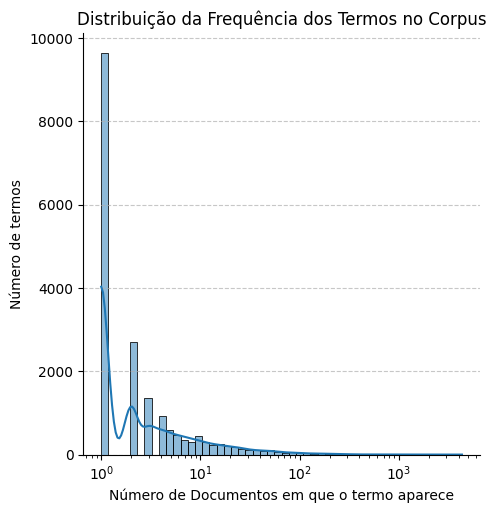

In [286]:
# plotando o histrogama da frequência dos termos
sns.displot(df_vocab, x=df_vocab['doc_freq'], kde=True, bins=50, log_scale=(True, False))
plt.ylabel('Número de termos')
plt.xlabel('Número de Documentos em que o termo aparece')
plt.title('Distribuição da Frequência dos Termos no Corpus')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

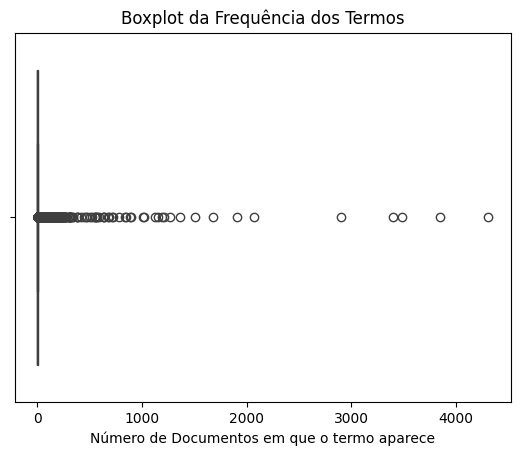

In [287]:
sns.boxplot(x=df_vocab['doc_freq'])
plt.xlabel('Número de Documentos em que o termo aparece')
plt.title('Boxplot da Frequência dos Termos')
plt.show()

In [288]:
vectorizer = TfidfVectorizer(min_df = 2)
X = vectorizer.fit_transform(sample["tokens"].apply(lambda tokens: " ".join(tokens)))
X.shape

(6072, 6836)

In [289]:
tfidf_matrix = pd.DataFrame(X.todense(), columns = vectorizer.get_feature_names_out())
tfidf_matrix

,aaron,aback,abandon,abbess,abbi,abduct,abductor,abe,abil,abl,...,yugoslavia,yuppi,zani,zatoichi,zealand,zero,zombi,zoo,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Redução de dimensionalidade, via Truncated SVD

In [290]:
n_components_full = X.shape[1]
svd_full = TruncatedSVD(n_components=n_components_full)
svd_full.fit(X)

TruncatedSVD(n_components=6836)

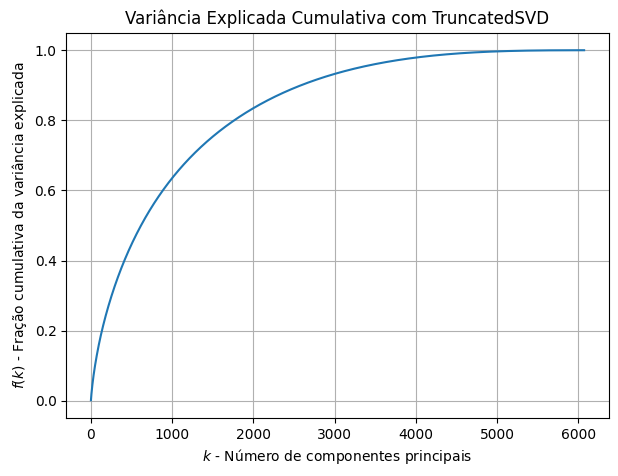

In [291]:
# plotando a variância cumulativa
cumulative_variance = np.cumsum(svd_full.explained_variance_ratio_)

plt.figure(figsize=(7, 5))
plt.plot(np.arange(1, min(X.shape[0], X.shape[1]) + 1), cumulative_variance)
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada')
plt.title('Variância Explicada Cumulativa com TruncatedSVD')
plt.grid(True)
plt.show()

In [292]:
new_n_components = 2500
svd = TruncatedSVD(n_components=new_n_components)
X2 = svd.fit_transform(X)
X2

array([[ 0.10669721, -0.05615992, -0.00695342, ..., -0.00256328,
        -0.00282068,  0.0104075 ],
       [ 0.05572841, -0.04233608,  0.00916699, ..., -0.01368963,
        -0.00405639,  0.0039492 ],
       [ 0.0784418 ,  0.01066507, -0.00956292, ..., -0.00441437,
         0.00236628,  0.00889159],
       ...,
       [ 0.15568488,  0.1171092 ,  0.17381013, ..., -0.01275946,
         0.01019648, -0.00172316],
       [ 0.03266925, -0.03561273, -0.0111112 , ...,  0.00396955,
         0.00547552,  0.00328042],
       [ 0.12402589,  0.11766362, -0.03689653, ..., -0.01231072,
        -0.0039524 , -0.00613602]], shape=(6072, 2500))

In [293]:
X2.shape

(6072, 2500)

### Calculando Inércia

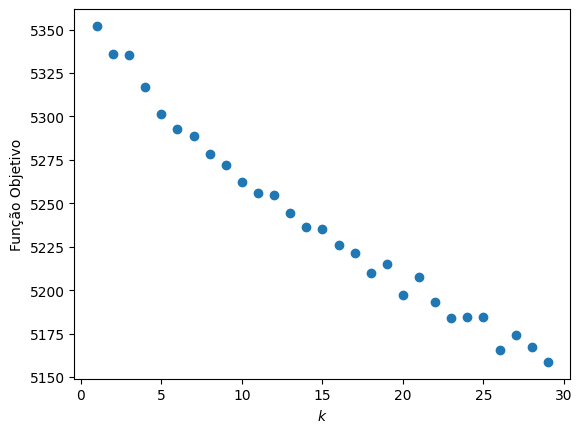

In [ ]:
# Inércial
inertia = []
for i in range(1, 30):
  km = KMeans(n_clusters = i)
  km.fit(X2.copy())
  inertia.append(km.inertia_)

# Scatter
plt.scatter(range(1, 30), inertia)
_ = plt.ylabel("Função Objetivo")
_ = plt.xlabel(r"$k$")

### KMeans

In [ ]:
# Clusterização
kmeans = KMeans(n_clusters = 20)
kmeans.fit(X2.copy())


y_kmeans = kmeans.predict(X2.copy())  # neste caso ele esta reprevendo os rotulos dos dados de treinamento, pois essa função é pra predizer novos dados
# ou y_means = kmeans.labels_ # Pega os rotulos dos dados de treinamento

# Vetor com os clusters de cada sinopse
y_kmeans

array([ 9,  7,  0, ...,  9,  9, 17], shape=(6072,), dtype=int32)

In [296]:
# Reduzindo dimensionalidade para o plot
pca = PCA(n_components=3)
X2_reduced = pca.fit_transform(X2.copy())
X2_reduced

array([[-0.04087345,  0.01318443,  0.0135517 ],
       [-0.04869072,  0.0068231 ,  0.04758781],
       [ 0.00471276, -0.01144362, -0.05538402],
       ...,
       [ 0.1672422 ,  0.15119834, -0.01969113],
       [-0.05814539, -0.01874359,  0.03238447],
       [ 0.11896796, -0.05577279,  0.05568622]], shape=(6072, 3))

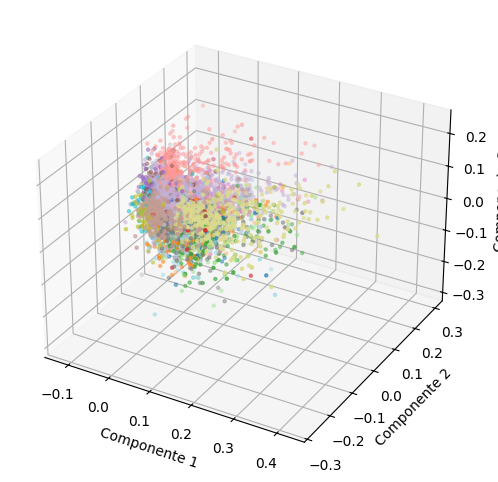

In [297]:
# Plotando  clusters em 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X2_reduced[:, 0], X2_reduced[:, 1], X2_reduced[:, 2], c=y_kmeans, cmap=plt.cm.tab20, s=5)

# Rótulos dos eixos
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

# plt.xlabel('Componente 1')
# plt.ylabel('Componente 2')
# plt.title('Visualização dos Clusters com KMeans')
# plt.colorbar(label='Cluster', ticks=range(20))
# plt.grid(True)
plt.show()

### Percentual de Gêneros em cada Cluster

In [298]:
# Criando nova coluna com os clusters
sample_kmeans = sample.copy()
sample_kmeans["cluster"] = y_kmeans
sample_kmeans

,sinopse,tokens,genres,cluster
21377,"Mike Braxton (Sam Jones) a St. Louis cop, rece...","[mike, braxton, sam, jone, st, loui, cop, rece...",Action,9
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...","Crime,Romance,Horror",7
8341,A couple struggles to visit all four of their ...,"[coupl, struggl, visit, four, divorc, parent, ...",Romance,0
14092,"Chaos ensues when a lethal, airborne virus inf...","[chao, ensu, lethal, airborn, viru, infect, po...","Crime,Action",9
12135,Josh's girlfriend wants to get married. Molly'...,"[josh, girlfriend, want, get, marri, molli, bo...",Romance,9
...,...,...,...,...
24560,"A 17-year-old dancer joins a ""thinspiration"" w...","[dancer, join, thinspir, websit, devot, almost...",Biography,16
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...","Sport,Romance",14
24943,A young woman Sasha meets a hippie leader and ...,"[young, woman, sasha, meet, hippi, leader, fin...",Romance,9
12923,Reporter Homer Smith accidentally draws Marcia...,"[report, homer, smith, accident, draw, marcia,...",Musical,9


In [299]:
# Separando Generos agrupados nas linhas
sample_kmeans["genres"] = sample_kmeans["genres"].str.split(',')
sample_kmeans = sample_kmeans.explode("genres")
sample_kmeans

,sinopse,tokens,genres,cluster
21377,"Mike Braxton (Sam Jones) a St. Louis cop, rece...","[mike, braxton, sam, jone, st, loui, cop, rece...",Action,9
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Crime,7
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Romance,7
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Horror,7
8341,A couple struggles to visit all four of their ...,"[coupl, struggl, visit, four, divorc, parent, ...",Romance,0
...,...,...,...,...
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...",Sport,14
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...",Romance,14
24943,A young woman Sasha meets a hippie leader and ...,"[young, woman, sasha, meet, hippi, leader, fin...",Romance,9
12923,Reporter Homer Smith accidentally draws Marcia...,"[report, homer, smith, accident, draw, marcia,...",Musical,9


In [300]:
# Agregando por (cluster + genero) para descobrir frequencia
genre_frequency_kmeans = sample_kmeans.groupby(["genres", "cluster"]).size().reset_index(name="freq")
genre_frequency_kmeans

# Transformando amostra em formato matricial
df_pivot_kmeans = genre_frequency_kmeans.pivot_table(index='genres', columns='cluster', values='freq', fill_value=0)
df_pivot_kmeans = df_pivot_kmeans.astype(int)

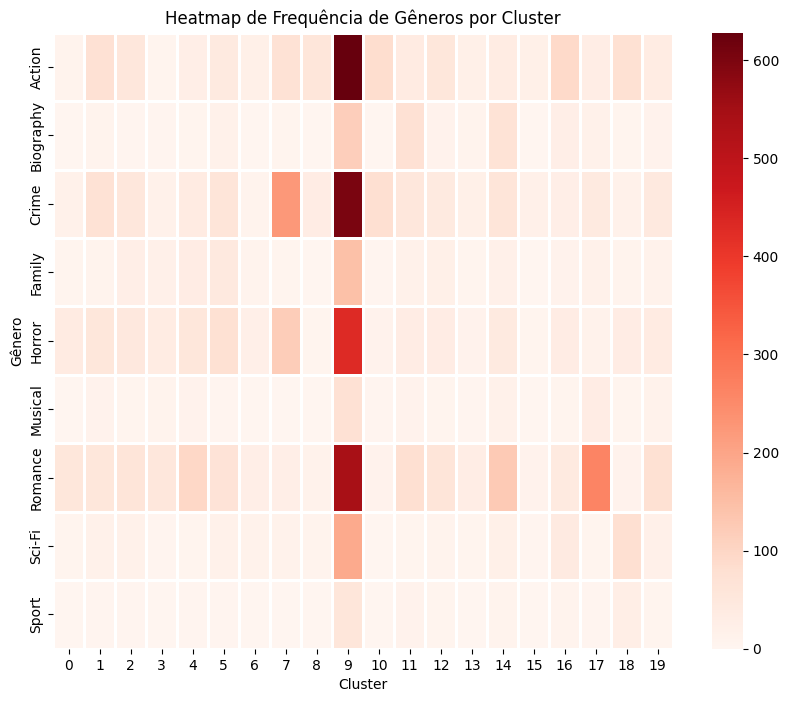

In [301]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_pivot_kmeans, cmap="Reds", linewidths=1)
plt.title('Heatmap de Frequência de Gêneros por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Gênero')
plt.show()

### Agrupamento Hierárquico Aglomerativo

In [302]:
X2

array([[ 0.10669721, -0.05615992, -0.00695342, ..., -0.00256328,
        -0.00282068,  0.0104075 ],
       [ 0.05572841, -0.04233608,  0.00916699, ..., -0.01368963,
        -0.00405639,  0.0039492 ],
       [ 0.0784418 ,  0.01066507, -0.00956292, ..., -0.00441437,
         0.00236628,  0.00889159],
       ...,
       [ 0.15568488,  0.1171092 ,  0.17381013, ..., -0.01275946,
         0.01019648, -0.00172316],
       [ 0.03266925, -0.03561273, -0.0111112 , ...,  0.00396955,
         0.00547552,  0.00328042],
       [ 0.12402589,  0.11766362, -0.03689653, ..., -0.01231072,
        -0.0039524 , -0.00613602]], shape=(6072, 2500))

In [314]:
from sklearn.cluster import AgglomerativeClustering

m = AgglomerativeClustering(linkage = 'average', n_clusters=20)
m.fit(X2.copy())

AgglomerativeClustering(linkage='single', n_clusters=5)

In [315]:
m.labels_

array([0, 0, 0, ..., 0, 0, 0], shape=(6072,))

In [304]:
sample_agglomerative = sample.copy()
sample_agglomerative["cluster"] = m.labels_
sample_agglomerative

,sinopse,tokens,genres,cluster
21377,"Mike Braxton (Sam Jones) a St. Louis cop, rece...","[mike, braxton, sam, jone, st, loui, cop, rece...",Action,0
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...","Crime,Romance,Horror",0
8341,A couple struggles to visit all four of their ...,"[coupl, struggl, visit, four, divorc, parent, ...",Romance,0
14092,"Chaos ensues when a lethal, airborne virus inf...","[chao, ensu, lethal, airborn, viru, infect, po...","Crime,Action",0
12135,Josh's girlfriend wants to get married. Molly'...,"[josh, girlfriend, want, get, marri, molli, bo...",Romance,0
...,...,...,...,...
24560,"A 17-year-old dancer joins a ""thinspiration"" w...","[dancer, join, thinspir, websit, devot, almost...",Biography,0
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...","Sport,Romance",0
24943,A young woman Sasha meets a hippie leader and ...,"[young, woman, sasha, meet, hippi, leader, fin...",Romance,0
12923,Reporter Homer Smith accidentally draws Marcia...,"[report, homer, smith, accident, draw, marcia,...",Musical,0


In [305]:
# Separando Generos agrupados nas linhas
sample_agglomerative["genres"] = sample_agglomerative["genres"].str.split(',')
sample_agglomerative = sample_agglomerative.explode("genres")
sample_agglomerative

,sinopse,tokens,genres,cluster
21377,"Mike Braxton (Sam Jones) a St. Louis cop, rece...","[mike, braxton, sam, jone, st, loui, cop, rece...",Action,0
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Crime,0
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Romance,0
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Horror,0
8341,A couple struggles to visit all four of their ...,"[coupl, struggl, visit, four, divorc, parent, ...",Romance,0
...,...,...,...,...
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...",Sport,0
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...",Romance,0
24943,A young woman Sasha meets a hippie leader and ...,"[young, woman, sasha, meet, hippi, leader, fin...",Romance,0
12923,Reporter Homer Smith accidentally draws Marcia...,"[report, homer, smith, accident, draw, marcia,...",Musical,0


In [306]:
# Agregando por (cluster + genero) para descobrir frequencia
genre_frequency_agglomerative = sample_agglomerative.groupby(["genres", "cluster"]).size().reset_index(name="freq")
genre_frequency_agglomerative

,genres,cluster,freq
0,Action,0,1436
1,Action,1,5
2,Action,2,3
3,Action,3,14
4,Action,4,2
...,...,...,...
82,Sci-Fi,14,1
83,Sci-Fi,16,3
84,Sci-Fi,19,1
85,Sport,0,145


In [307]:
# Transformando amostra em formato matricial
df_pivot_agglomerative = genre_frequency_agglomerative.pivot_table(index='genres', columns='cluster', values='freq', fill_value=0)
df_pivot_agglomerative = df_pivot_agglomerative.astype(int)

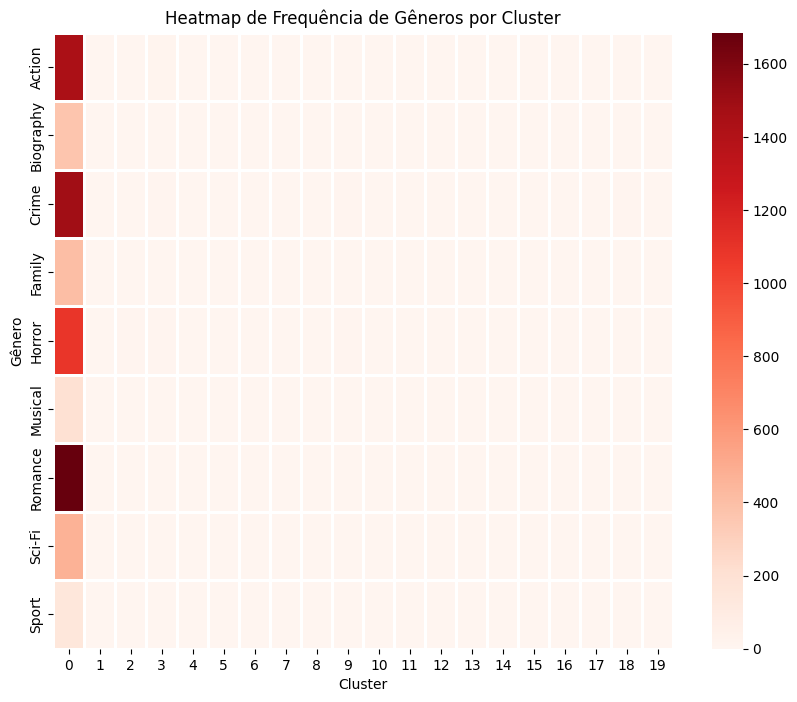

In [308]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_pivot_agglomerative, cmap="Reds", linewidths=1)
plt.title('Heatmap de Frequência de Gêneros por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Gênero')
plt.show()

### Agrupamento Espectral

In [317]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=20, assign_labels='discretize', random_state=0).fit(X2.copy())
spectral.labels_

array([10, 18,  0, ..., 12,  4, 17], shape=(6072,))

In [318]:
sample_spectral = sample.copy()
sample_spectral["cluster"] = spectral.labels_
sample_spectral

,sinopse,tokens,genres,cluster
21377,"Mike Braxton (Sam Jones) a St. Louis cop, rece...","[mike, braxton, sam, jone, st, loui, cop, rece...",Action,10
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...","Crime,Romance,Horror",18
8341,A couple struggles to visit all four of their ...,"[coupl, struggl, visit, four, divorc, parent, ...",Romance,0
14092,"Chaos ensues when a lethal, airborne virus inf...","[chao, ensu, lethal, airborn, viru, infect, po...","Crime,Action",13
12135,Josh's girlfriend wants to get married. Molly'...,"[josh, girlfriend, want, get, marri, molli, bo...",Romance,2
...,...,...,...,...
24560,"A 17-year-old dancer joins a ""thinspiration"" w...","[dancer, join, thinspir, websit, devot, almost...",Biography,1
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...","Sport,Romance",11
24943,A young woman Sasha meets a hippie leader and ...,"[young, woman, sasha, meet, hippi, leader, fin...",Romance,12
12923,Reporter Homer Smith accidentally draws Marcia...,"[report, homer, smith, accident, draw, marcia,...",Musical,4


In [319]:
# Separando Generos agrupados nas linhas
sample_spectral["genres"] = sample_spectral["genres"].str.split(',')
sample_spectral = sample_spectral.explode("genres")
sample_spectral

,sinopse,tokens,genres,cluster
21377,"Mike Braxton (Sam Jones) a St. Louis cop, rece...","[mike, braxton, sam, jone, st, loui, cop, rece...",Action,10
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Crime,18
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Romance,18
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Horror,18
8341,A couple struggles to visit all four of their ...,"[coupl, struggl, visit, four, divorc, parent, ...",Romance,0
...,...,...,...,...
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...",Sport,11
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...",Romance,11
24943,A young woman Sasha meets a hippie leader and ...,"[young, woman, sasha, meet, hippi, leader, fin...",Romance,12
12923,Reporter Homer Smith accidentally draws Marcia...,"[report, homer, smith, accident, draw, marcia,...",Musical,4


In [320]:
genre_frequency_spectral = sample_spectral.groupby(["genres", "cluster"]).size().reset_index(name="freq")
genre_frequency_spectral

,genres,cluster,freq
0,Action,0,25
1,Action,1,105
2,Action,2,95
3,Action,3,35
4,Action,4,376
...,...,...,...
173,Sport,14,6
174,Sport,15,1
175,Sport,16,5
176,Sport,18,1


In [321]:
df_pivot_spectral = genre_frequency_spectral.pivot_table(index='genres', columns='cluster', values='freq', fill_value=0)
df_pivot_spectral = df_pivot_spectral.astype(int)

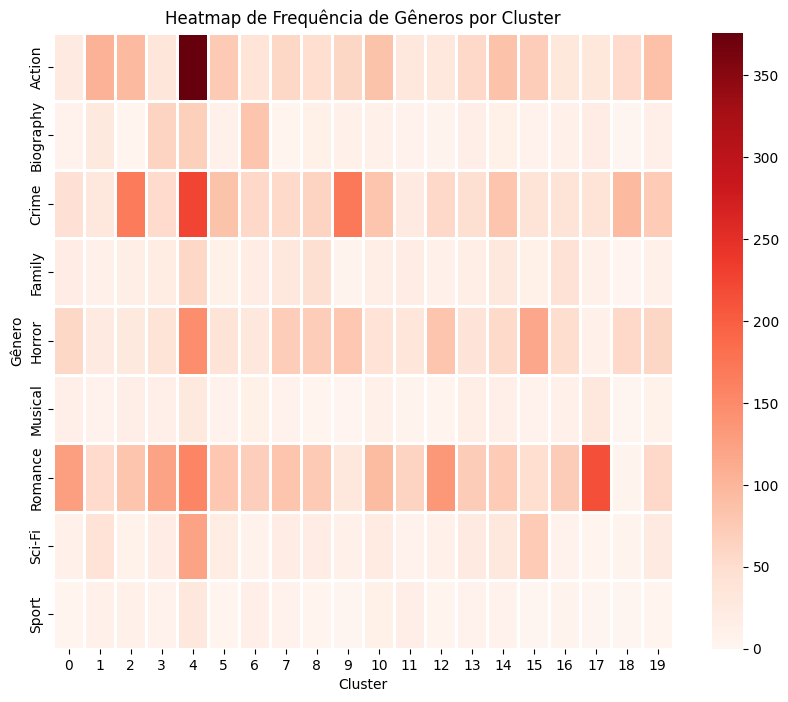

In [322]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_pivot_spectral, cmap="Reds", linewidths=1)
plt.title('Heatmap de Frequência de Gêneros por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Gênero')
plt.show()